Taken from: http://minds.jacobs-university.de/sites/default/files/uploads/mantas/code/minimalESN.py.txt
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas Lukosevicius  2012
http://minds.jacobs-university.de/mantas


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.linalg

In [4]:
# load the data
trainLen = 2000
testLen = 2000
initLen = 100

data = loadtxt('09-MackeyGlass_t17.txt')


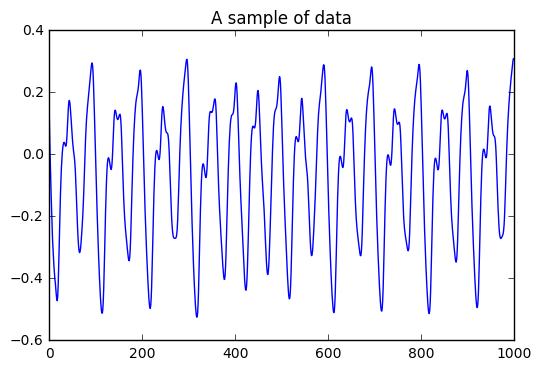

In [5]:
plot(data[0:1000])
title('A sample of data')

In [6]:
# generate the ESN reservoir
inSize = outSize = 1
resSize = 1000
a = 0.3 # leaking rate

random.seed(42)
Win = (random.rand(resSize,1+inSize)-0.5) * 1
W = random.rand(resSize,resSize)-0.5 

print 'Computing spectral radius...',
rhoW = max(abs(linalg.eig(W)[0]))
print 'done.'
W *= 1.25 / rhoW

Computing spectral radius... done.


In [7]:
# allocated memory for the design (collected states) matrix
X = zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1] 

# run the reservoir with the data and collect X
x = zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = vstack((1,u,x))[:,0]


In [8]:
# train the output
reg = 1e-8  # regularization coefficient
X_T = X.T
Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + 
    reg*eye(1+inSize+resSize) ) )

In [9]:
# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    y = dot( Wout, vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 


In [10]:
# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( square( data[trainLen+1:trainLen+errorLen+1] - Y[0,0:errorLen] ) ) / errorLen
print 'MSE = ' + str( mse )


MSE = 1.5536263508e-06


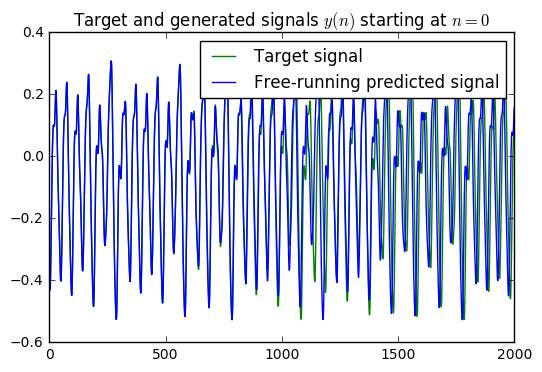

In [11]:
plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plot( Y.T, 'b' )
title('Target and generated signals $y(n)$ starting at $n=0$')
legend(['Target signal', 'Free-running predicted signal'])


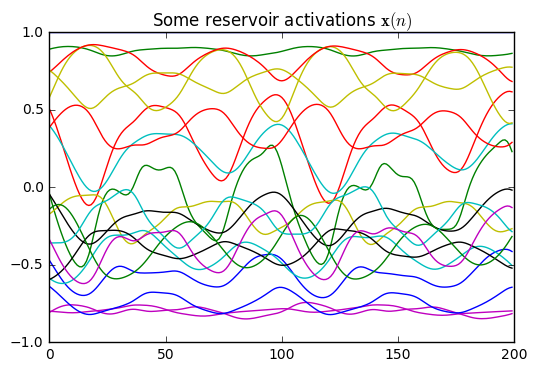

In [12]:
plot( X[0:20,0:200].T )
title('Some reservoir activations $\mathbf{x}(n)$')


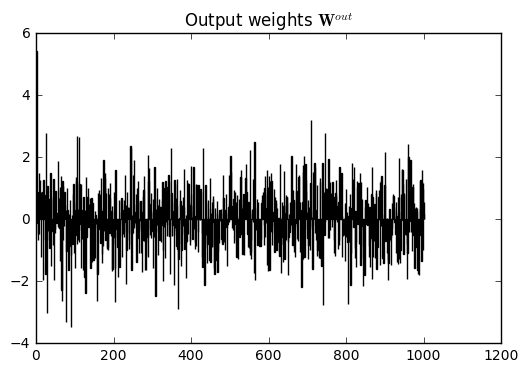

In [13]:
bar( range(1+inSize+resSize), Wout.T )
title('Output weights $\mathbf{W}^{out}$')
